In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import (GradientBoostingClassifier)
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import itertools
from sklearn.metrics import log_loss
warnings.filterwarnings('ignore')

In [2]:
# load and inspect the final_dataset
df = pd.read_parquet('Data Cleaning/final_dataset2.parquet')

In [3]:
comma_separated_names = ','.join(df['official_name'].astype(str))

# Write to file
with open('official_names.txt', 'w') as file:
    file.write(comma_separated_names)

In [4]:
def prepare_features_with_engineering(df):
    """
    Prepare features with additional feature engineering
    """
    # Create copy to avoid modifying original
    df_feat = df.copy()
    
    # Ensure numeric columns are properly typed
    numeric_cols = ['speakers', 'official', 'regional', 'minority', 'national', 
                   'widely_spoken', 'country_count', 'max_urbanization', 
                   'max_internet_use']
    
    for col in numeric_cols:
        if col in df_feat.columns:
            df_feat[col] = pd.to_numeric(df_feat[col], errors='coerce').fillna(0)
    
    # Add ratio features
    df_feat['urbanization_internet_product'] = df_feat['max_urbanization'] * df_feat['max_internet_use']
    df_feat['official_national_sum'] = df_feat['official'] + df_feat['national']
    df_feat['minority_regional_sum'] = df_feat['minority'] + df_feat['regional']
    
    # Log transform skewed features
    df_feat['log_speakers'] = np.log1p(df_feat['speakers'])
    
    # Interaction features
    df_feat['speakers_urbanization'] = df_feat['speakers'] * df_feat['max_urbanization']
    df_feat['speakers_internet'] = df_feat['speakers'] * df_feat['max_internet_use']
    
    # Replace any infinities or NaNs
    df_feat = df_feat.replace([np.inf, -np.inf], 0)
    df_feat = df_feat.fillna(0)
    
    return df_feat

In [5]:
def handle_class_imbalance(X_train, y_train, method='class_weight'):
    """
    Handle class imbalance using available methods
    """
    try:
        from imblearn.over_sampling import SMOTE, ADASYN
        from imblearn.combine import SMOTETomek
        HAS_IMBALANCED_LEARN = True
    except ImportError:
        HAS_IMBALANCED_LEARN = False
        print("imbalanced-learn not available. Install with: pip install imbalanced-learn")

    if HAS_IMBALANCED_LEARN and method == 'smote':
        smote = SMOTE(random_state=42, k_neighbors=min(5, min(np.bincount(y_train)) - 1))
        return smote.fit_resample(X_train, y_train)
    else:
        # Return original data if SMOTE not available
        return X_train, y_train

In [6]:
def train_gradient_boosting_model(df):
    """
    Train Gradient Boosting model (sklearn version)
    """
    print("Training Gradient Boosting model...")
    
    # Prepare features
    df_feat = prepare_features_with_engineering(df)
    
    # Select features
    feature_cols = list(df.columns[4:12]) + [
        'urbanization_internet_product', 
        'official_national_sum', 'minority_regional_sum',
        'log_speakers',
        'speakers_urbanization', 'speakers_internet'
    ]
    
    X = df_feat[feature_cols]
    y = df_feat['level']
    
    # Split into train (80) and test (20)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Then split train into train (60) and val (20)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.25, stratify=y_train, random_state=42
    )
    
    # Scale features
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_val_scaled = scaler.transform(X_val)

    # Handle class imbalance
    X_train_balanced, y_train_balanced = handle_class_imbalance(X_train_scaled, y_train)
    
    # Train Gradient Boosting
    gb_model = GradientBoostingClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )
    
    gb_model.fit(X_train_balanced, y_train_balanced)
    
    # Predictions
    y_pred = gb_model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    y_val_pred = gb_model.predict(X_val_scaled)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    
    print(f"Validation Accuracy: {val_accuracy:.3f}")
    print(f"Test Accuracy: {accuracy:.3f}")

    print("\nValidation Classification Report:")
    print(classification_report(y_val, y_val_pred))
    print("\nTest Classification Report:")
    print(classification_report(y_test, y_pred))
    
    return gb_model, scaler, feature_cols, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, X_train_balanced, y_train_balanced

In [7]:
gb_model, scaler, features, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, X_train_balanced, y_train_balanced = train_gradient_boosting_model(df)

Training Gradient Boosting model...
Validation Accuracy: 0.709
Test Accuracy: 0.723

Validation Classification Report:
                       precision    recall  f1-score   support

              At risk       0.70      0.54      0.61        13
Critically Endangered       0.80      0.68      0.73        77
           Endangered       0.70      0.73      0.72       130
              Extinct       0.97      0.97      0.97        35
       Not Endangered       1.00      1.00      1.00        18
  Severely Endangered       0.54      0.42      0.47        67
           Threatened       0.68      0.83      0.75       149
           Vulnerable       0.64      0.58      0.61        85

             accuracy                           0.71       574
            macro avg       0.75      0.72      0.73       574
         weighted avg       0.71      0.71      0.70       574


Test Classification Report:
                       precision    recall  f1-score   support

              At risk       0

In [8]:
def gboost_tuner(param_dict, X_train, y_train, X_val, y_val):
    best_model = None
    best_score = 0
    best_params = {}

    for est, depth, lr, ss in itertools.product(
        param_dict['n_estimators'],
        param_dict['max_depth'],
        param_dict['learning_rate'],
        param_dict['subsample']
    ):
        model = GradientBoostingClassifier(
            n_estimators=est,
            max_depth=depth,
            learning_rate=lr,
            subsample=ss,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42
        )

        model.fit(X_train, y_train)
        val_preds = model.predict(X_val)
        val_acc = accuracy_score(y_val, val_preds)
        val_proba = model.predict_proba(X_val)
        val_loss = log_loss(y_val, val_proba)
        print(f"Trying: est={est}, depth={depth}, lr={lr}, ss={ss} --> val_acc={val_acc:.4f}, val_loss={val_loss:.4f}")

        if val_acc > best_score:
            best_score = val_acc
            best_loss = val_loss
            best_model = model
            best_params = {
                'n_estimators': est,
                'max_depth': depth,
                'learning_rate': lr,
                'subsample': ss
            }

    print("Best validation accuracy:", best_score)
    print("Corresponding log loss:", best_loss)
    print("Best hyperparameters:", best_params)
    return best_model, best_score, best_loss, best_params

In [9]:
tuning_dict = {
    'n_estimators': [50, 100, 200],
    'max_depth': [1, 3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.6, 0.8]
}

best_model, best_score, best_loss, best_params = gboost_tuner(
    tuning_dict,
    X_train_balanced,
    y_train_balanced,
    X_val_scaled,
    y_val
)

Trying: est=50, depth=1, lr=0.05, ss=0.6 --> val_acc=0.7352, val_loss=0.8592
Trying: est=50, depth=1, lr=0.05, ss=0.8 --> val_acc=0.7334, val_loss=0.8574
Trying: est=50, depth=1, lr=0.1, ss=0.6 --> val_acc=0.7509, val_loss=0.7950
Trying: est=50, depth=1, lr=0.1, ss=0.8 --> val_acc=0.7474, val_loss=0.7900
Trying: est=50, depth=3, lr=0.05, ss=0.6 --> val_acc=0.7439, val_loss=0.7769
Trying: est=50, depth=3, lr=0.05, ss=0.8 --> val_acc=0.7491, val_loss=0.7811
Trying: est=50, depth=3, lr=0.1, ss=0.6 --> val_acc=0.7474, val_loss=0.7658
Trying: est=50, depth=3, lr=0.1, ss=0.8 --> val_acc=0.7474, val_loss=0.7693
Trying: est=50, depth=5, lr=0.05, ss=0.6 --> val_acc=0.7474, val_loss=0.7826
Trying: est=50, depth=5, lr=0.05, ss=0.8 --> val_acc=0.7474, val_loss=0.7762
Trying: est=50, depth=5, lr=0.1, ss=0.6 --> val_acc=0.7334, val_loss=0.8305
Trying: est=50, depth=5, lr=0.1, ss=0.8 --> val_acc=0.7300, val_loss=0.8296
Trying: est=100, depth=1, lr=0.05, ss=0.6 --> val_acc=0.7491, val_loss=0.7906
Tryi

In [16]:
def plot_feature_importance(model, feature_names, model_name, X_test=None, y_test=None, 
                          scaler=None, use_permutation=False):
    """
    Plot feature importance for a given model
    """
    plt.figure(figsize=(10, 8))
    
    if use_permutation and X_test is not None and y_test is not None:
        # Use permutation importance for models without built-in feature importance
        if scaler is not None:
            X_test_scaled = scaler.transform(X_test)
        else:
            X_test_scaled = X_test
            
        perm_importance = permutation_importance(model, X_test_scaled, y_test, 
                                               n_repeats=10, random_state=42)
        importances = perm_importance.importances_mean
        std_devs = perm_importance.importances_std
    else:
        # Use built-in feature importance
        importances = model.feature_importances_
        std_devs = None
    
    # Create dataframe for sorting
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=True)
    
    # Create horizontal bar plot
    bars = plt.barh(importance_df['feature'], importance_df['importance'])
    
    # Color bars by importance
    colors = plt.cm.viridis(importance_df['importance'] / importance_df['importance'].max())
    for bar, color in zip(bars, colors):
        bar.set_color(color)
    
    # Add value labels
    for i, (idx, row) in enumerate(importance_df.iterrows()):
        plt.text(row['importance'] + 0.001, i, f'{row["importance"]:.3f}', 
                va='center', fontsize=9)
    
    plt.xlabel('Feature Importance', fontsize=12)
    plt.title(f'{model_name} - Feature Importance', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print top 10 features
    print(f"\nTop 10 Features for {model_name}:")
    print(importance_df.nlargest(10, 'importance').to_string(index=False))

def plot_all_feature_importances(gb_model, features):
    """
    Plot feature importances for all models
    """
    print("=" * 60)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("=" * 60)
    
    # 1. Gradient Boosting
    if gb_model is not None:
        plot_feature_importance(gb_model, features, "Gradient Boosting")
    

def create_feature_importance_comparison(gb_model, features):
    """
    Create a comparison heatmap of feature importances across tree-based models
    """
    models_with_importance = []
    importance_matrix = []
    
    if gb_model is not None and hasattr(gb_model, 'feature_importances_'):
        models_with_importance.append('Gradient Boosting')
        importance_matrix.append(gb_model.feature_importances_)
    
    if len(importance_matrix) > 1:
        # Create heatmap
        plt.figure(figsize=(12, 8))
        
        # Normalize importances for better comparison
        importance_matrix = np.array(importance_matrix)
        importance_matrix = importance_matrix / importance_matrix.sum(axis=1, keepdims=True)
        
        # Create dataframe
        importance_df = pd.DataFrame(importance_matrix.T, 
                                   index=features,
                                   columns=models_with_importance)
        
        # Sort by average importance
        importance_df['Average'] = importance_df.mean(axis=1)
        importance_df = importance_df.sort_values('Average', ascending=False)
        importance_df = importance_df.drop('Average', axis=1)
        
        # Plot heatmap
        sns.heatmap(importance_df.head(20).T, cmap='YlOrRd', annot=True, fmt='.3f', 
                    cbar_kws={'label': 'Normalized Importance'})
        plt.title('Feature Importance Comparison Across Models (Top 20)', 
                  fontsize=14, fontweight='bold')
        plt.xlabel('Features', fontsize=12)
        plt.ylabel('Models', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

def analyze_feature_correlations(df, features, top_n=10):
    """
    Analyze correlations between top features
    """
    # Prepare features
    df_feat = prepare_features_with_engineering(df)
    
    # Get feature data
    feature_data = df_feat[features]
    
    # Calculate correlation matrix
    corr_matrix = feature_data.corr()
    
    # Plot correlation heatmap for top features
    plt.figure(figsize=(10, 8))
    
    # Select top features based on variance
    top_features = feature_data.var().nlargest(top_n).index.tolist()
    
    sns.heatmap(corr_matrix.loc[top_features, top_features], 
                annot=True, fmt='.2f', cmap='coolwarm', center=0,
                square=True, linewidths=1)
    plt.title(f'Feature Correlation Matrix (Top {top_n} by Variance)', 
              fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


FEATURE IMPORTANCE ANALYSIS


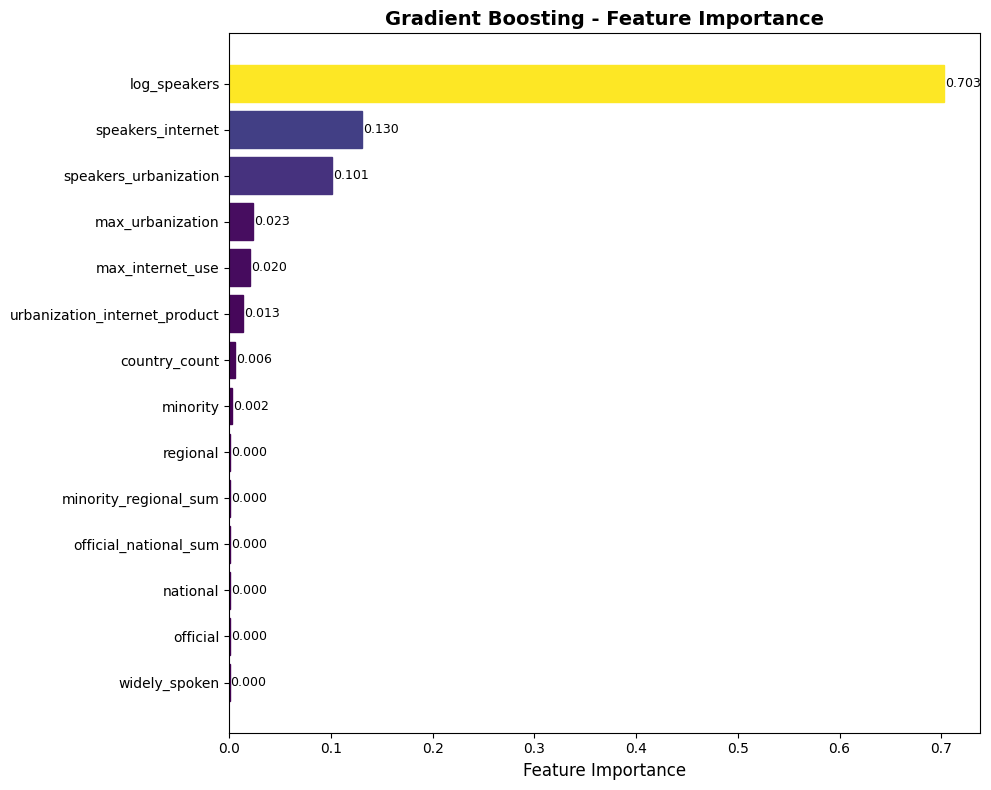


Top 10 Features for Gradient Boosting:
                      feature  importance
                 log_speakers    0.702999
            speakers_internet    0.130013
        speakers_urbanization    0.100712
             max_urbanization    0.022974
             max_internet_use    0.020446
urbanization_internet_product    0.013362
                country_count    0.005683
                     minority    0.002257
                     regional    0.000443
        minority_regional_sum    0.000441


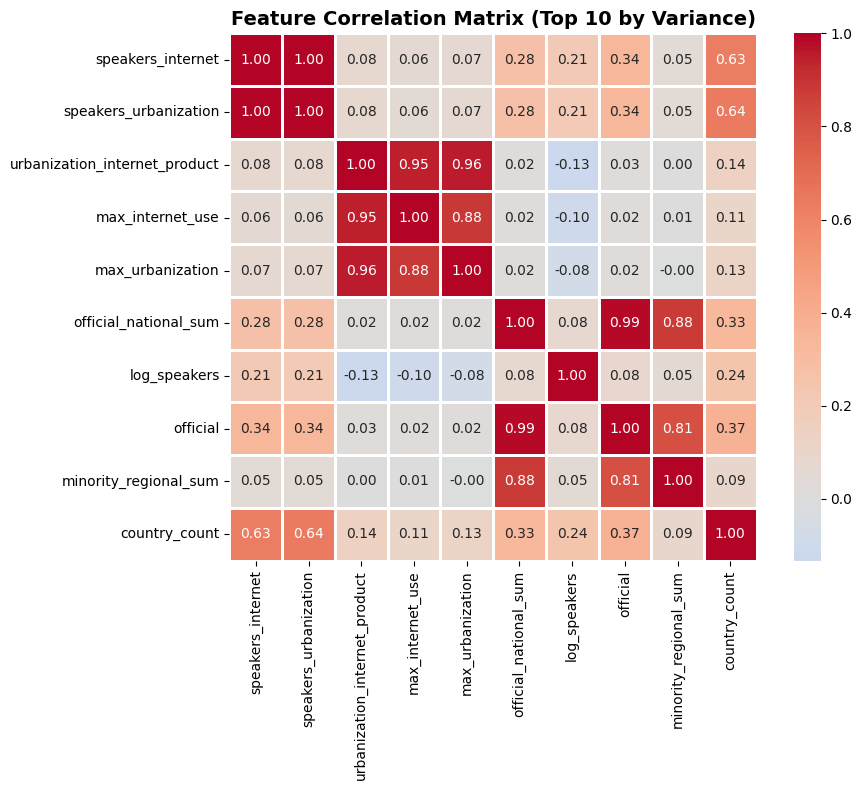

In [17]:
plot_all_feature_importances(best_model, features)

# Comparison heatmap:
create_feature_importance_comparison(best_model, features)

# Feature correlation analysis:
analyze_feature_correlations(df, features)